In [44]:
import itertools

from dataclasses import dataclass, field
from tqdm.notebook import tqdm

import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors


@dataclass
class Climber:
    level: float
    std: float
    _estimated_level: float = 1000
    estimated_std: float = 7
    history: list = field(default_factory=list)
    success: list = field(default_factory=list)
    t: float = 0.2

    @property
    def estimated_level(self):
        return self._estimated_level

    @estimated_level.setter
    def estimated_level(self, x):
        # if hasattr(self, '_history'):
        self.history.append(self.estimated_level)
        self._estimated_level = x

@dataclass
class Route:
    difficulty: float
    _estimated_difficulty: float = 1000
    history: list = field(default_factory=list)

    @property
    def estimated_difficulty(self):
        return self._estimated_difficulty

    @estimated_difficulty.setter
    def estimated_difficulty(self, x):
        # if hasattr(self, '_history'):
        self.history.append(self._estimated_difficulty)
        self._estimated_difficulty = x

In [45]:
k = 20

def climb(climber: Climber, route: Route):
    m, s = climber.estimated_level, climber.estimated_std
    climber_score = np.random.normal(climber.level, climber.std)
    route_score = route.estimated_difficulty
    
    # probability of a success
    expected_outcome = 1 - sts.norm(m, s).cdf(route_score)

    # we can estimate the variance of this random variable
    # k should be high if it is low, and vice versa
    

    # experiment result
    res = climber_score > route.difficulty

    # l = len(climber.history) + 2
    # K = k * (np.log(l) / l + 1)

    # update the climber stats accordingly
    climber.estimated_level +=  k * (res - expected_outcome)
    # the std should also be updated
    
    climber.success.append(res)
    # climber.estimated_std *= (1 - climber.t)
    # climber.t *= 0.9
    
    # update the route estimated difficulty
    route.estimated_difficulty += k * (expected_outcome - res)

### Comment ajuster dans le même temps l'espérance et la variance ?

Il s'agit de maximiser la vraisemblance de l'expérience sachant les a priori.

Est-ce que la fonction de vraisemblance est convexe en $(m, s)$ ?

Si oui, il s'agit de faire une descente de gradient à chaque itération.

In [46]:
n_routes = 64
n_climbers = 64

routes = np.random.random(n_routes) * 2000
routes.sort()

climbers = np.random.normal(1000, 200, n_climbers)
climbers_std = np.random.gamma(14, 1, n_climbers)

climbers = [Climber(i, j) for i, j in zip(climbers, climbers_std)]
routes = [Route(i) for i in routes]

n_attempts = 2**16

# you do not want to use random.choice and store the objects in memory
# but you also do not want to do the random sampling in a python loop
cs = np.random.randint(0, len(climbers), n_attempts)
rs = np.random.randint(0, len(routes), n_attempts)

difficulties = np.array([r.difficulty for r in routes])

for i, j in tqdm(zip(cs, rs), total=n_attempts):
    climb(climbers[i], routes[j])
    # c = climbers[i]
    # self_estimated_level = np.random.normal(c.level, c.std * 4)
    # r = routes[np.argmin(np.abs(self_estimated_level - difficulties))]
    # climb(c, r)

  0%|          | 0/65536 [00:00<?, ?it/s]

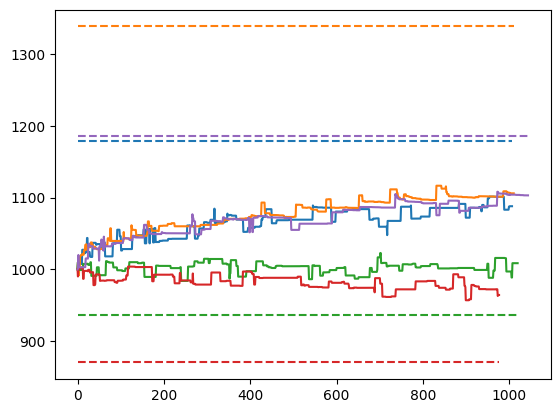

In [47]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)

def plot_convergence(c: Climber):
    color = next(color_cycle)
    plt.plot(c.history, color=color)
    plt.hlines(c.level, 0, len(c.history), color=color, linestyle='--')

for c in climbers[:5]:
    plot_convergence(c)

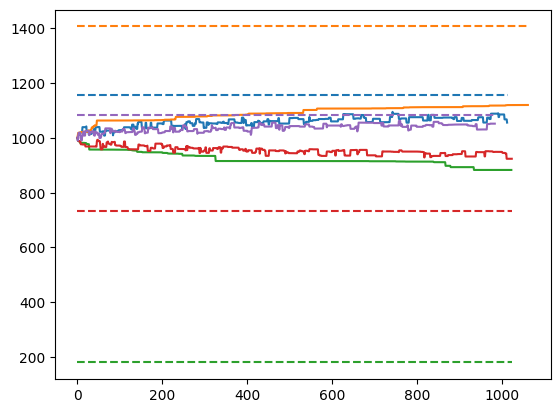

In [48]:
color_cycle = itertools.cycle(mplcolors.TABLEAU_COLORS)

def plot_convergence(c: Route):
    color = next(color_cycle)
    plt.plot(c.history, color=color)
    plt.hlines(c.difficulty, 0, len(c.history), color=color, linestyle='--')

for c in np.random.choice(routes, 5, replace=False):
    plot_convergence(c)

In [49]:
np.array([len(c.history) for c in climbers]).mean()

1024.0

In [50]:
np.array([s for c in climbers for s in c.success]).mean()

0.5953216552734375